In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\Joaquín Amat\\Documents\\GitHub\\skforecast'

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDiff import ForecasterAutoregDiff
from sklearn.linear_model import LinearRegression   
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

Train dates : 1991-07-01 00:00:00 --- 2003-03-01 00:00:00  (n=141)
Test dates  : 2003-04-01 00:00:00 --- 2008-06-01 00:00:00  (n=63)


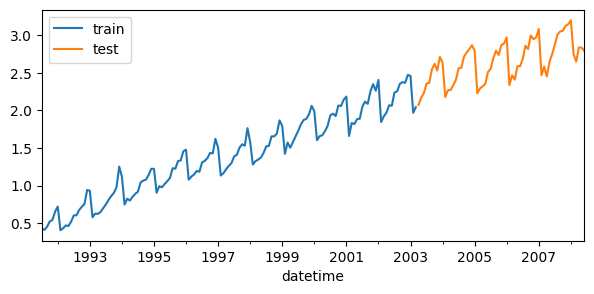

In [30]:

# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Add a smooth positive trend
# ==============================================================================
t = np.arange(len(data))
data = data + 0.01 * t

# Data partition train-test
# ==============================================================================
end_train = '2003-03-01 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

2003-04-01    2.158064
2003-05-01    2.249131
2003-06-01    2.321235
2003-07-01    2.328289
2003-08-01    2.379777
Freq: MS, Name: pred, dtype: float64

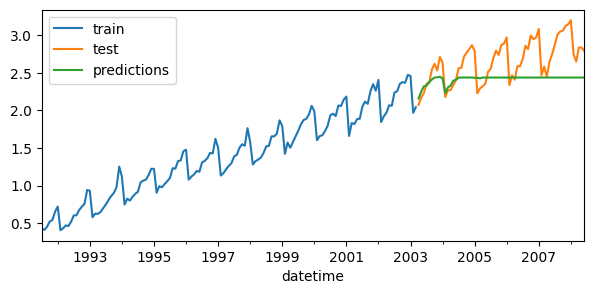

In [31]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(n_estimators=200), #LinearRegression(),
                 lags      = 15
             )

forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
display(predictions.head())

2003-04-01    2.279310
2003-05-01    2.352464
2003-06-01    2.387842
2003-07-01    2.507433
2003-08-01    2.524370
Freq: MS, Name: pred, dtype: float64

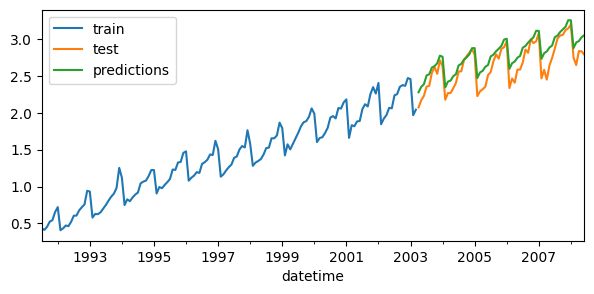

In [32]:
forecaster = ForecasterAutoregDiff(
                 regressor       = RandomForestRegressor(random_state=12345678), #LinearRegression(),
                 lags            = 15,
                 differentiation = 1
            )

forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
display(predictions.head())

2003-04-01    2.288405
2003-05-01    2.400501
2003-06-01    2.423429
2003-07-01    2.468294
2003-08-01    2.518413
Freq: MS, Name: pred, dtype: float64

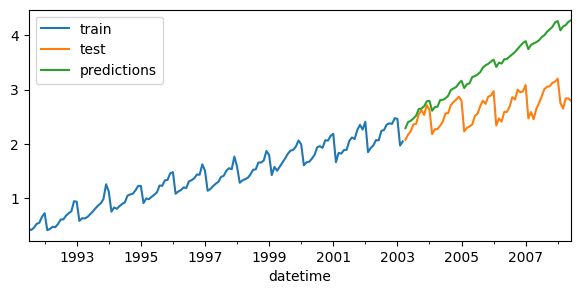

In [42]:
forecaster = ForecasterAutoregDiff(
                 regressor       = HistGradientBoostingRegressor(random_state=12345678, max_iter=20), #LinearRegression(),
                 lags            = 15,
                 differentiation = 1
            )

forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
display(predictions.head())

2003-04-01    2.082794
2003-05-01    2.216194
2003-06-01    2.236635
2003-07-01    2.368247
2003-08-01    2.398062
Freq: MS, Name: pred, dtype: float64

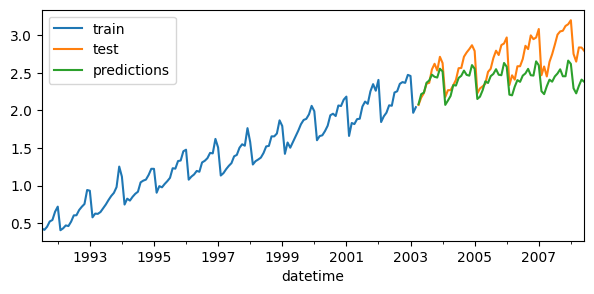

In [17]:
forecaster = ForecasterAutoreg(
                 regressor  = LinearForestRegressor(
                                base_estimator=LinearRegression(),
                                max_features='sqrt'
                            ),
                 lags       = 15,
            )

forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();
display(predictions.head())

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class TimeSeriesDifferentiator(BaseEstimator, TransformerMixin):
    """
    Transforms a time series into a differentiated time series of order n.
    It also reverts the differentiation.

    Parameters
    ----------
    order : int
        Order of differentiation.

    Attributes
    ----------
    initial_values : list
        List with the initial value the time series after each differentiation.
        This is used to revert the differentiation.
    order : int
        Order of differentiation.   

    """
    
    def __init__(self, order=1):

        self.order = order
        self.initial_values = []
    

    def fit(self, X, y: Any=None):
        """
        Fits the transformer. This method does nothing.

        Parameters
        ----------
        X : array-like of shape (n_samples,)
            Time series to be differentiated.
        y : None
            Ignored.

        Returns
        -------
        self : object
        
        """

        self.initial_values = []

        return self
    

    def transform(self, X, y: Any=None):
        """
        Transforms a time series into a differentiated time series of order n.

        Parameters
        ----------
        X : array-like of shape (n_samples,)
            Time series to be differentiated.
        y : None
            Ignored.
        
        Returns
        -------
        X_diff : array-like of shape (n_samples,)
            Differentiated time series.

        """

        for i in range(self.order):
            if i == 0:
                self.initial_values.append(X[0])
                X_diff = np.diff(X, n=1)
            else:
                self.initial_values.append(X_diff[0])
                X_diff = np.diff(X_diff, n=1)
                
        X_diff = np.append((np.full(shape=self.order, fill_value=np.nan)), X_diff)

        return X_diff
    
    
    def inverse_transform(self, X, y: Any=None):
        """
        Reverts the differentiation.

        Parameters
        ----------
        X : array-like of shape (n_samples,)
            Differentiated time series.
        y : None
            Ignored.
        
        Returns
        -------
        X_diff : array-like of shape (n_samples,)
            Reverted differentiated time series.

        """

        # Remove initial nan values if present
        X = X[np.argmax(~np.isnan(X)):]
        print("Initial values:", self.initial_values)
        for i in range(self.order):
            if i == 0:
                X_diff = np.insert(X, 0, self.initial_values[self.order-1])
                X_diff = np.cumsum(X_diff, dtype=float)
            else:
                X_diff = np.insert(X_diff, 0, self.initial_values[self.order-i-1])
                X_diff = np.cumsum(X_diff, dtype=float)

        return X_diff



# Generate a sample time series
X = np.arange(10)
X = np.random.randint(0, 10, 10)

# Differentiate the time series up to order 1
differentiator = TimeSeriesDifferentiator(order=4)
differentiator.fit(X)
X_diff = differentiator.transform(X)



# Revert the differentiation
X_reverted = differentiator.inverse_transform(X_diff)

# Print the original time series, the differentiated time series, and the reverted time series
print(f"Original time series: {X}")
print(f"Differentiated time series: {X_diff}")
print(f"Reverted time series: {X_reverted}")

Tr 1: [ 2 -5  2  4 -4  2  0  2 -3]
Tr 2: [-7  7  2 -8  6 -2  2 -5]
Tr 2: [ 14  -5 -10  14  -8   4  -7]
Tr 2: [-19  -5  24 -22  12 -11]
Initial values: [3, 2, -7, 14]
1 iTr: [ 14. -19.  -5.  24. -22.  12. -11.]
1 iTr: [ 14.  -5. -10.  14.  -8.   4.  -7.]
2 iTr: [ -7.  14.  -5. -10.  14.  -8.   4.  -7.]
2 iTr: [-7.  7.  2. -8.  6. -2.  2. -5.]
2 iTr: [ 2. -7.  7.  2. -8.  6. -2.  2. -5.]
2 iTr: [ 2. -5.  2.  4. -4.  2.  0.  2. -3.]
2 iTr: [ 3.  2. -5.  2.  4. -4.  2.  0.  2. -3.]
2 iTr: [3. 5. 0. 2. 6. 2. 4. 4. 6. 3.]
Original time series: [3 5 0 2 6 2 4 4 6 3]
Differentiated time series: [ nan  nan  nan  nan -19.  -5.  24. -22.  12. -11.]
Reverted time series: [3. 5. 0. 2. 6. 2. 4. 4. 6. 3.]
